<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit4/Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



## Task1

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
chem_data_url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv"
chem_data = pd.read_csv(chem_data_url)
chem_data.insert(loc=4, column="diff_t_e", value=(chem_data.theo - chem_data.exp))

In [3]:
chem_aa_encode = pd.Categorical(chem_data['aa'])
chem_aa_idx = chem_aa_encode.codes
chem_aa_coords = {"aa": chem_aa_encode.categories}

### Old Model

In [4]:
with pm.Model(coords=chem_aa_coords) as chem_model_old:
    # Hyperpriors
    μ_μ = pm.Normal('μ->μ', mu=0, sigma=10)
    μ_σ = pm.HalfNormal('μ->σ', sigma=10)

    # Priors
    μ = pm.Normal('μ',
                  mu=μ_μ,
                  sigma=μ_σ,
                  dims="aa")
    σ = pm.HalfNormal('σ', sigma=10,
                      dims="aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu=μ[chem_aa_idx],
                  sigma=σ[chem_aa_idx],
                  observed=chem_data.diff_t_e)

    #cs for chemshift, h for heirarchical
    chem_idata_old = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ->μ, μ->σ, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


### New Model

In [5]:
import preliz as pz
pz.StudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

In [6]:
pz.HalfStudentT().plot_interactive()

interactive(children=(FloatSlider(value=7.0, description='nu (0, inf)', max=17.0, min=2.220446049250313e-16, s…

In [7]:
with pm.Model(coords=chem_aa_coords) as chem_model_new:
    # Hyperpriors
    μ_ν = pm.HalfStudentT("μ->ν", nu=1, sigma=1)
    μ_μ = pm.StudentT("μ->μ", nu=1, mu=0, sigma=1)
    μ_σ = pm.HalfStudentT("μ->σ", nu=1, sigma=1)
    
    
    # Priors
    ν = pm.HalfStudentT("ν",
                        nu=1,
                        sigma=1,
                        dims="aa")
    # It is reasonable for μ to have hyperpriors, because μ seems to be more affected by category (I think)
    μ = pm.StudentT("μ",
                    nu=μ_ν,
                    mu=μ_μ,
                    sigma=μ_σ,
                    dims="aa")
    σ = pm.HalfStudentT("σ",
                        nu=1,
                        sigma=1,
                        dims="aa")
    
    # Likelihood
    y = pm.StudentT("y",
                    nu=ν[chem_aa_idx],
                    mu=μ[chem_aa_idx],
                    sigma=σ[chem_aa_idx],
                    observed=chem_data.diff_t_e)

    chem_idata_new = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ->ν, μ->μ, μ->σ, ν, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


### Comparison (ridge plot)

array([<Axes: >], dtype=object)

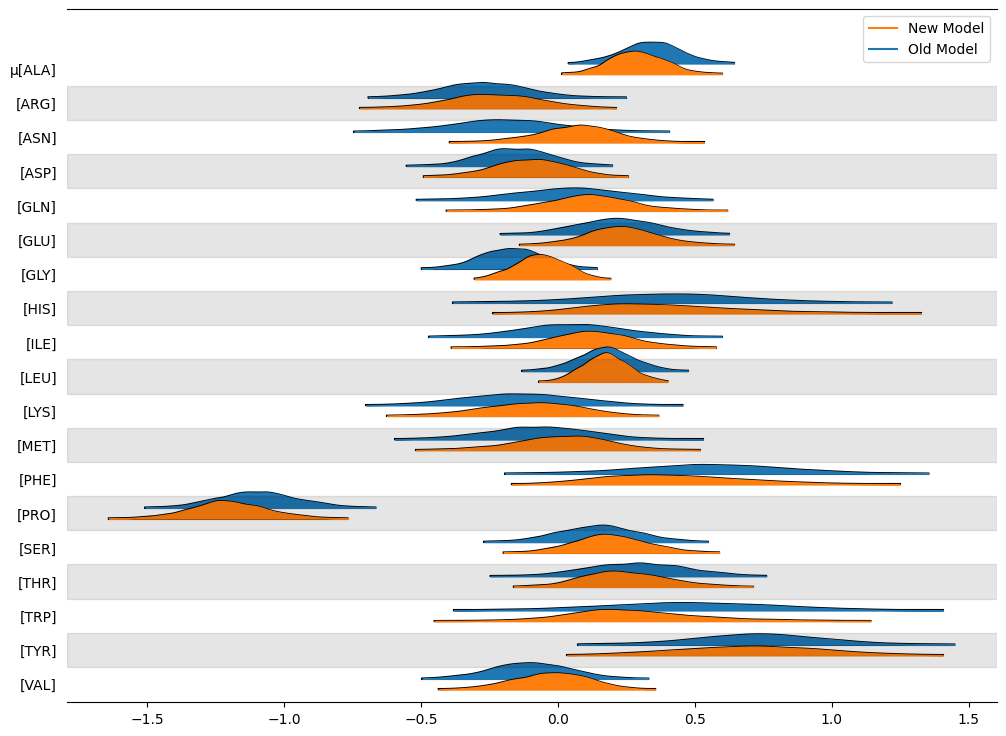

In [8]:
az.plot_forest([chem_idata_old, chem_idata_new],
               model_names=["Old Model", "New Model"],
               kind="ridgeplot", var_names='μ', combined=True, figsize=(12, 9), hdi_prob=0.997)

The models produce roughly the same results. For `ASN`, `GLY`, and `PRO` there are especially pronounced shifts between the two, but mostly the ranges are the same. In general, there doesn't seem to be a trend between the height and shift difference between the two models. From this graph alone, I can't tell which model better fits the data.

## Task2

Run a posterior predictive check for both models. Which seems to fit the data better?

In [9]:
pm.sample_posterior_predictive(chem_idata_old, model=chem_model_old, extend_inferencedata=True)
pm.sample_posterior_predictive(chem_idata_new, model=chem_model_new, extend_inferencedata=True)

Sampling: [y]


Output()

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

[None]

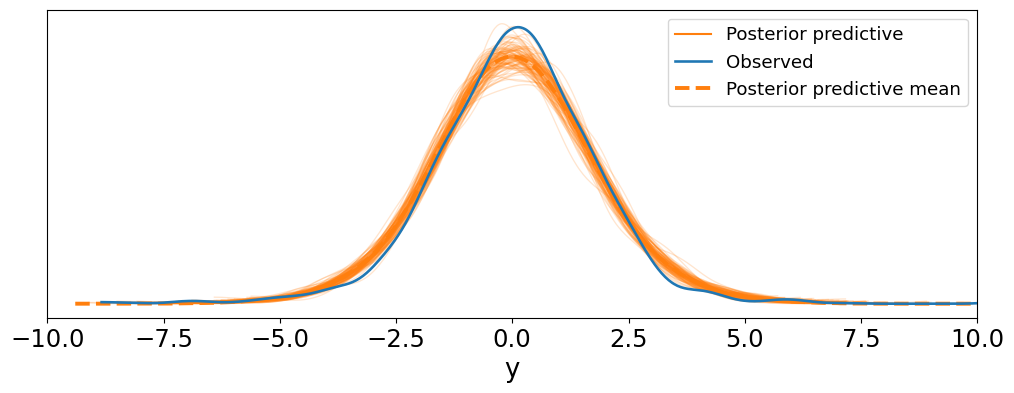

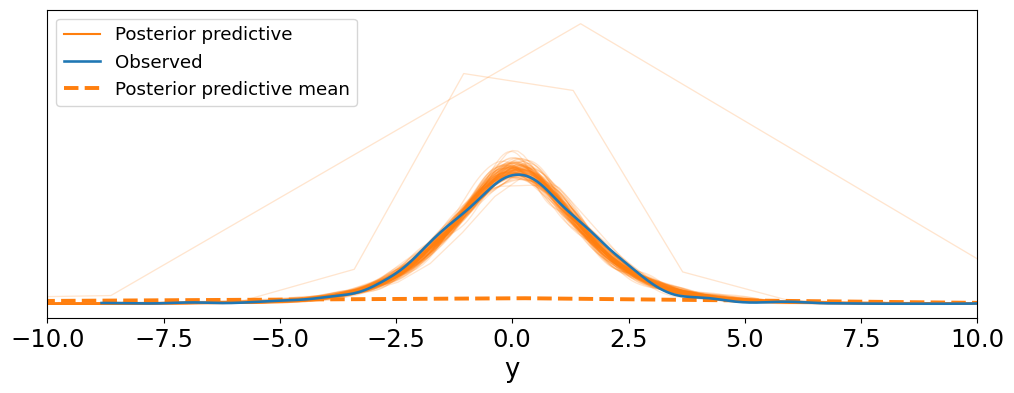

In [10]:
az.plot_ppc(chem_idata_old, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set(xbound=(-10, 10))
az.plot_ppc(chem_idata_new, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set(xbound=(-10, 10))

## Task3

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [2]:
soccer_data_url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv"
soccer_data = pd.read_csv(soccer_data_url, dtype={"position": "category"})

In [4]:
soccer_pos_idx = soccer_data.position.cat.codes.values
soccer_pos_codes = soccer_data.position.cat.categories
soccer_coords = {"pos": soccer_pos_codes}
print(soccer_pos_idx, soccer_pos_codes, soccer_coords)

[1 0 3 ... 3 3 0] Index(['DF', 'FW', 'GK', 'MF'], dtype='object') {'pos': Index(['DF', 'FW', 'GK', 'MF'], dtype='object')}


In [13]:
with pm.Model(coords=soccer_coords) as soccer_model_new:
    # Parameters
    μ_p = pm.Beta('μ_p', alpha=0.9, beta=55, dims="pos") # Prior based on means of hyperpriors in old dist
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[soccer_pos_idx], nu = ν_p[soccer_pos_idx])

    _ = pm.Binomial('gs',
                    n=soccer_data.shots.values, # Shots for each player
                    p=θ, # Guess of goals per shot
                    observed=soccer_data.goals.values) # Goals per player

    soccer_idata_new = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_p, ν_p, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 234 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Task4

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

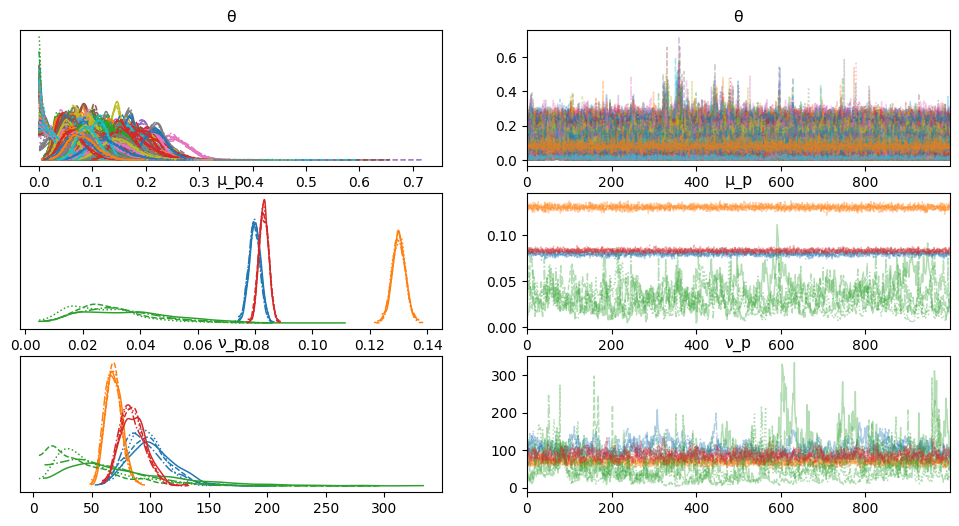

In [14]:
az.plot_trace(soccer_idata_new)

In [15]:
az.rhat(soccer_idata_new)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.002 1.002 ... 0.9995 0.9996 1.001
    μ_p      (pos) float64 32B 1.003 1.001 1.101 1.001
    ν_p      (pos) float64 32B 1.016 1.004 1.123 1.009

### Trace

Hierarchical model trace, for comparison:

![](trace-soccer-hierarchical.png)

For `μ_p`, the main difference is the green line, which is most likely goalkeeper data. In the non-hierarchical model, it has a smaller range and has less outliers. On the left graph, this can be seen by the curve being generally concentrated around 0.02–0.04 for the non-hierarchical model, as opposed to the wider graph for the hierarchical model. On the right graph, this can be seen by the greater y-variability of the hierarchical model.

For `ν_p`, once again, the hierarchical model has more variability in all curves than the non-hierarchical model.

### $\hat{R}$ values

Hierarchical model values, for comparison:

![](rhat-soccer-hierarchical.png)

In terms of $\hat{R}$ values, the difference between the two models was not too pronounced and a little inconsistent. In general, the non-hierarchical model has lower $\hat{R}$ values for all positions except FW. The reason why the non-hierarchical model has lower $\hat{R}$ values is probably is because in the hierarchical model, the GK values are significantly different from the rest of the data, and therefore influence it more significantly. In the non-hierarchical model, however, this influence doesn't cause problems because it doesn't exist.

## Task5

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

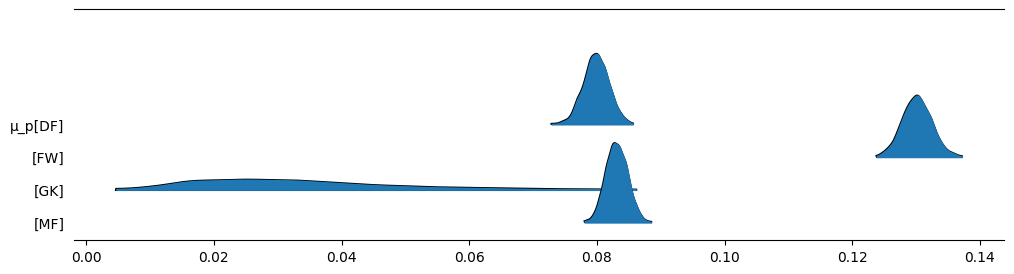

In [16]:
az.plot_forest(soccer_idata_new, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

Hierarchical plot, for comparison:

![](forest-soccer-hierarchical.png)

Compared to the hierarchical model, the non-hierarchical one has graphs what are taller and narrower. It also has shorter tails (meaning that there are less outliers). Since the goalkeeper data is significantly different from the other positions, it exerts a large "flattening" influence in the hierarchical model, which explains the observed changes.

## Task6

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [60]:
fixed_soccer_data = soccer_data[soccer_data["position"] != "GK"]
fixed_soccer_data = fixed_soccer_data.assign(position=fixed_soccer_data["position"].cat.remove_unused_categories())

In [61]:
fixed_soccer_pos_idx = fixed_soccer_data.position.cat.codes.values
fixed_soccer_pos_codes = fixed_soccer_data.position.cat.categories
fixed_soccer_coords = {"pos": fixed_soccer_pos_codes}

In [63]:
with pm.Model(coords=fixed_soccer_coords) as soccer_model_fixed:
    # Hyperparameters
    μ = pm.Beta('μ', alpha=2, beta=20)
    ν = pm.Gamma('ν', mu=55, sigma=45)


    # Parameters for positions
    μ_p = pm.Beta('μ->p', mu=μ, nu=ν, dims="pos")

    ν_p = pm.Gamma('ν->p', mu=55, sigma=45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu=μ_p[fixed_soccer_pos_idx], nu = ν_p[fixed_soccer_pos_idx])

    _ = pm.Binomial('gs',
                    n=fixed_soccer_data.shots.values, # Shots for each player
                    p=θ, # Guess of goals per shot
                    observed=fixed_soccer_data.goals.values) # Goals per player

    soccer_idata_fixed = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ->p, ν->p, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ->p'}>,
        <Axes: title={'center': 'μ->p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν->p'}>,
        <Axes: title={'center': 'ν->p'}>]], dtype=object)

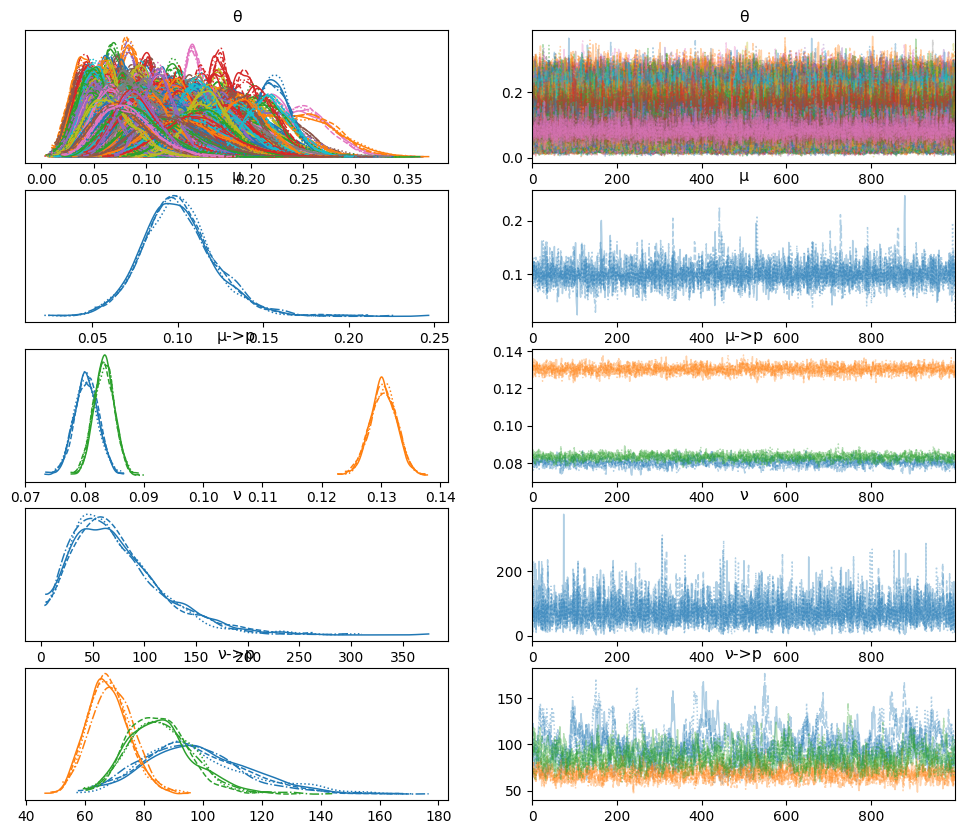

In [65]:
az.plot_trace(soccer_idata_fixed)

In [66]:
az.rhat(soccer_idata_fixed)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.004 1.003 1.0 1.003 ... 1.002 1.002 1.001
    μ        float64 8B 1.0
    μ->p     (pos) float64 24B 1.001 1.001 1.003
    ν        float64 8B 1.0
    ν->p     (pos) float64 24B 1.01 1.004 1.007

array([<Axes: >], dtype=object)

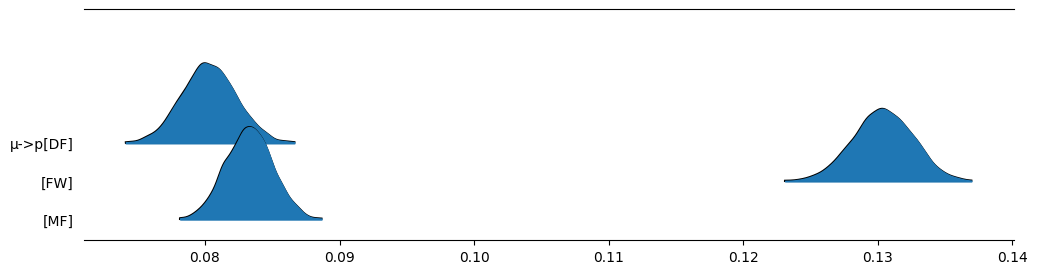

In [67]:
az.plot_forest(soccer_idata_fixed, var_names=['μ->p'], combined=True, figsize=(12, 3), kind="ridgeplot", hdi_prob=0.998)

## Task7

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

- Both took long to process and plot on my end. The model with the dropped GK's ran faster than the regular hierarchical model.
- Droping goalkeepers, we no longer have a posterior model for the GK's, and we lose the affect that GK's have on the other player data. However, we gain posteriors that are much more similar to their respective data values. Perhaps this is more accurate, considering the fact that goalkeepers are a separate class of their own in terms of shooting goals.